In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepfake-faces/metadata.csv
/kaggle/input/deepfake-faces/faces_224/zrivvmjwai.jpg
/kaggle/input/deepfake-faces/faces_224/twdzulstzv.jpg
/kaggle/input/deepfake-faces/faces_224/qviyhxvysb.jpg
/kaggle/input/deepfake-faces/faces_224/tgbciglpoi.jpg
/kaggle/input/deepfake-faces/faces_224/emzxydfgar.jpg
/kaggle/input/deepfake-faces/faces_224/dqxwrxwjcu.jpg
/kaggle/input/deepfake-faces/faces_224/zzylooqabq.jpg
/kaggle/input/deepfake-faces/faces_224/hunpbscjol.jpg
/kaggle/input/deepfake-faces/faces_224/vqvpqosovt.jpg
/kaggle/input/deepfake-faces/faces_224/vvtgxgykww.jpg
/kaggle/input/deepfake-faces/faces_224/hqcnaesvmg.jpg
/kaggle/input/deepfake-faces/faces_224/gjjxjtgugw.jpg
/kaggle/input/deepfake-faces/faces_224/tnyzsuxdqk.jpg
/kaggle/input/deepfake-faces/faces_224/xphgqcimqk.jpg
/kaggle/input/deepfake-faces/faces_224/tcawfspikr.jpg
/kaggle/input/deepfake-faces/faces_224/zgjnbmzbgl.jpg
/kaggle/input/deepfake-faces/faces_224/wgfmaikyin.jpg
/kaggle/input/deepfake-faces/faces_224/k

In [2]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [3]:
tf.test.is_gpu_available()
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))


DEVICES AVAILABLE: 2


In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:


import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

meta=get_data()
meta.head()






videoname  original_width  original_height label        original
0  aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1  gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2  lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3  itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4  ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4

In [7]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [8]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 15000
fake_df = fake_df.sample(sample_size, random_state=42)
sample_meta = pd.concat([real_df, fake_df])

In [9]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.15,random_state=42,stratify=Train_set['label'])

In [10]:
Train_set.shape,Val_set.shape,Test_set.shape

((21278, 5), (3756, 5), (6259, 5))

In [12]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

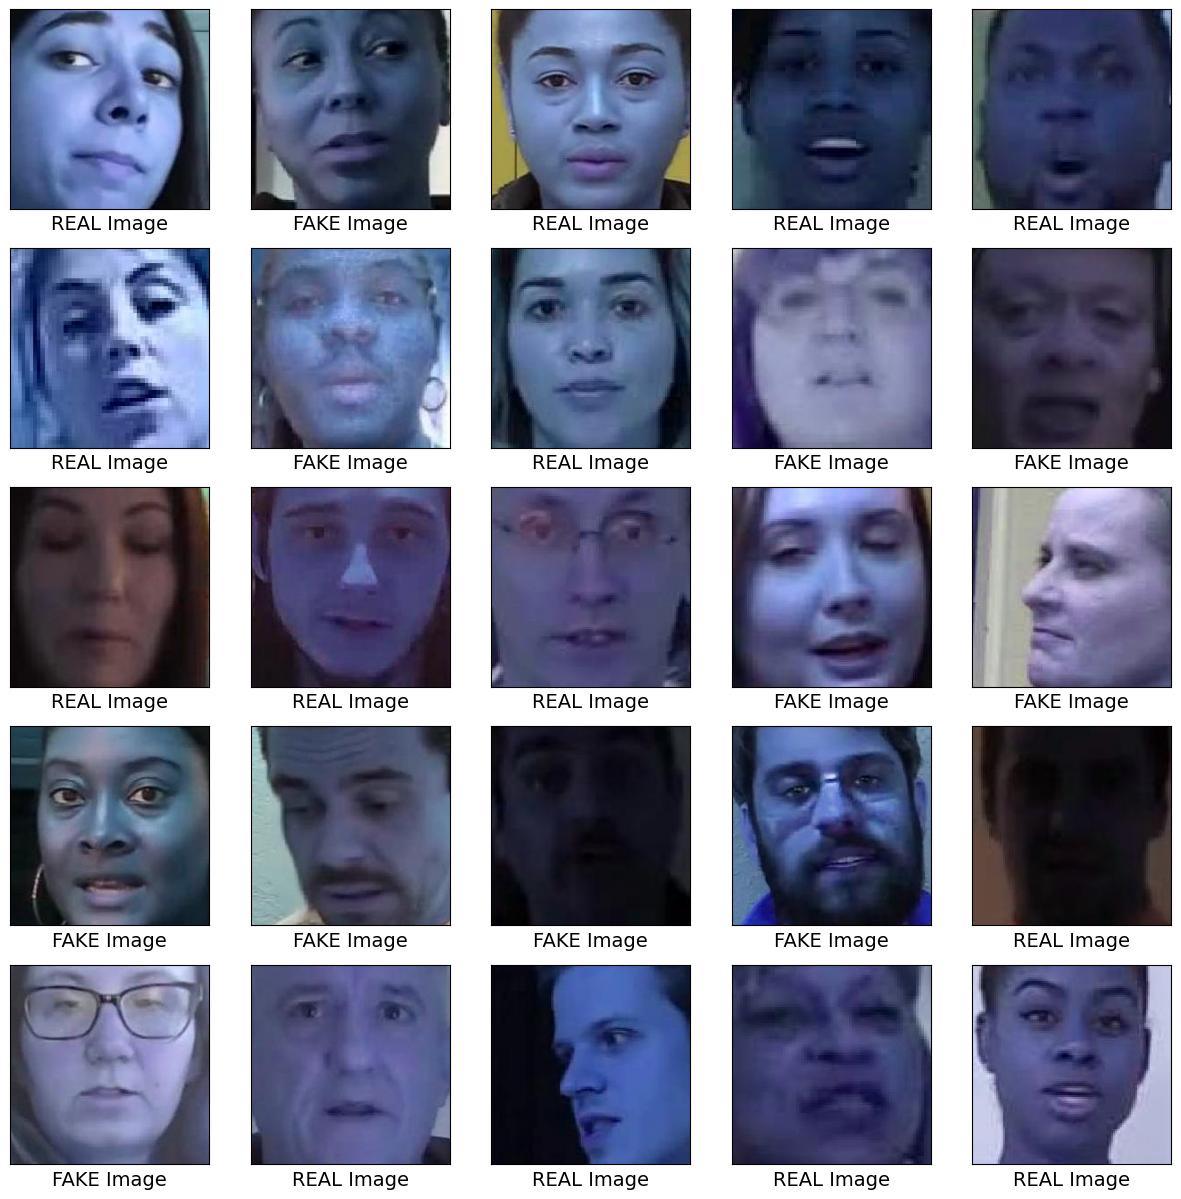

In [13]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

In [15]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [16]:


X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)



In [17]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [18]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size_per_replica = 32
batch_size = batch_size_per_replica
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

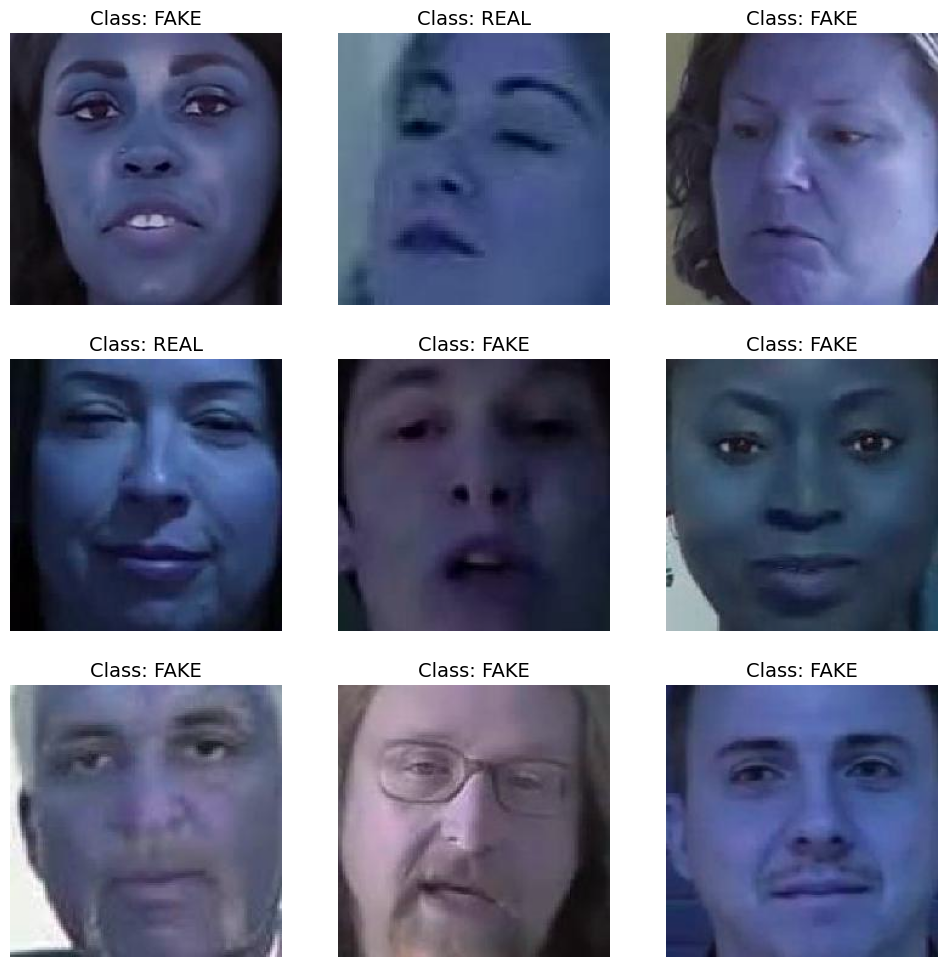

In [19]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

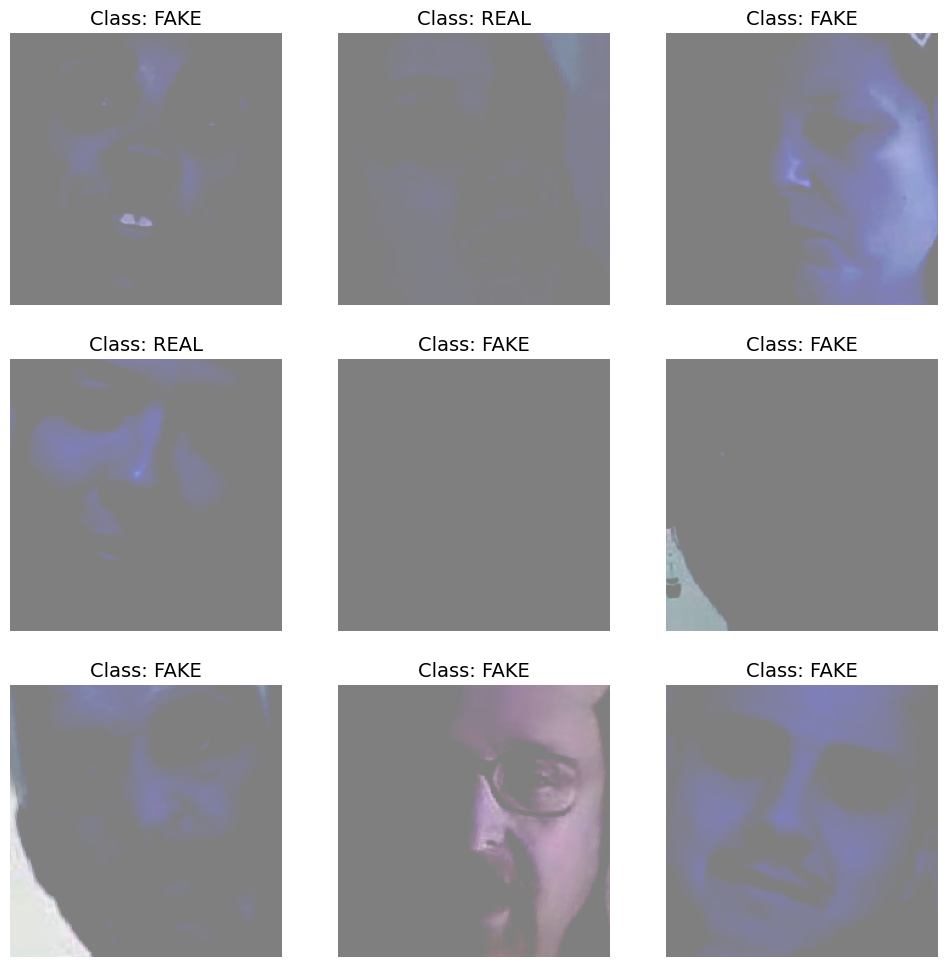

In [21]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [22]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [23]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10


I0000 00:00:1731858771.633433     100 service.cc:145] XLA service 0x783528001350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731858771.634041     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731858771.634052     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731858798.411639     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 ━━━━━━━━━━━━━━━━━━━━ 363s 484ms/step - accuracy: 0.6563 - loss: 0.5987 - val_accuracy: 0.7465 - val_loss: 0.5303
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 438ms/step - accuracy: 0.8382 - loss: 0.3512 - val_accuracy: 0.6683 - val_loss: 1.1930
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 437ms/step - accuracy: 0.9099 - loss: 0.2119 - val_accuracy: 0.8158 - val_loss: 0.4808
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 438ms/step - accuracy: 0.9451 - loss: 0.1444 - val_accuracy: 0.8498 - val_loss: 0.4481
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 438ms/step - accuracy: 0.9661 - loss: 0.0945 - val_accuracy: 0.8379 - val_loss: 0.5639
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 437ms/step - accuracy: 0.9721 - loss: 0.0718 - val_accuracy: 0.8544 - val_loss: 0.5224
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 437ms/step - accuracy: 0.9764 - loss: 0.0641 - val_accuracy: 0.8727 - val_loss: 0.4885
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 291s 438ms/step - accuracy: 0.9823 - loss: 0.04

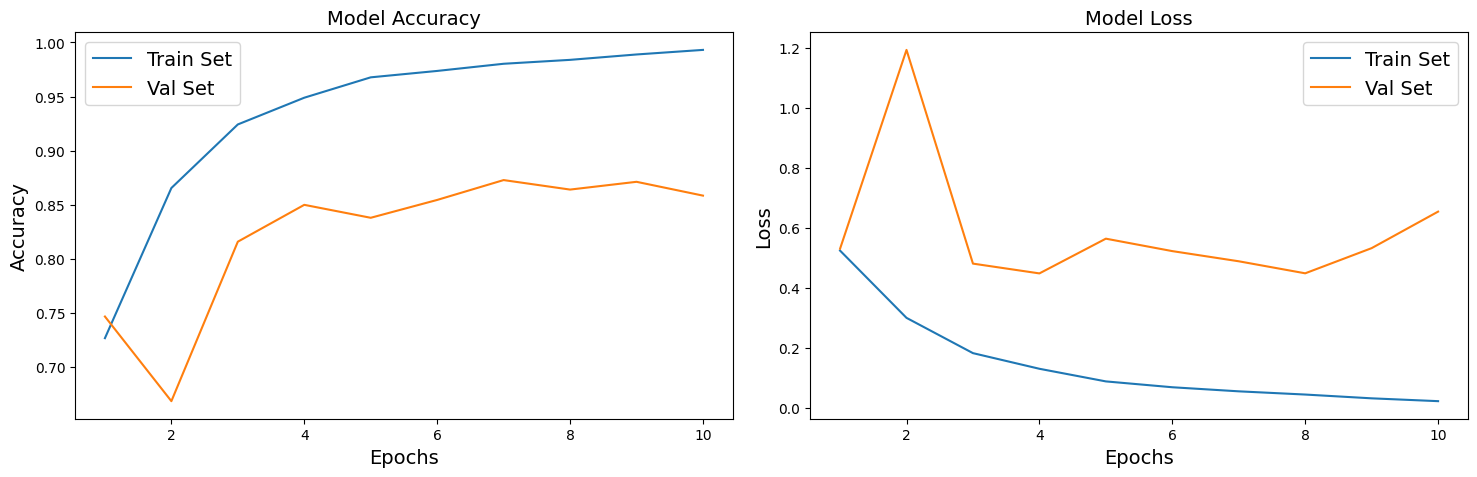

In [24]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [25]:
model.save('/kaggle/working/fake_video_detector_model.h5')